In [1]:
# Import libraries
import torch
import torch.nn as nn
from torch import optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)

from PIL import Image
from sklearn.model_selection import train_test_split
from datetime import datetime

from pathlib import Path

# Custom modules and packages
import params.learning
import uncertainty.functions
import uncertainty.evaluation
from utils import compute_mean_std
from dataset import TraversabilityDataset
from model import ResNet18Velocity_Regression_Alt
from train import train
from validate import validate
from test import test, test_models
from result import parameters_table, generate_log
from custom_transforms import Cutout, Shadowcasting

from params import PROJECT_PATH

## Load learning parameters

In [2]:
LEARNING_PARAMS = params.learning.LEARNING
NET_PARAMS = params.learning.NET_PARAMS

## Prepare data

#### Compute the mean and the standard deviation of the images set

In [3]:
# Load pre-computed mean and std
NORMALIZE_PARAMS = params.learning.NORMALIZE_PARAMS

normalize_params_recompute = False

if normalize_params_recompute:
    mean, std = compute_mean_std("images_train", "traversal_costs_train.csv")
    NORMALIZE_PARAMS = {
        "rbg": {"mean": mean[:3], "std": std[:3]},
        "depth": {"mean": mean[3], "std": std[3]},
        "normal": {"mean": mean[4:], "std": std[4:]},
    }

print(NORMALIZE_PARAMS)

{'rbg': {'mean': tensor([0.4710, 0.5030, 0.4580]), 'std': tensor([0.1965, 0.1859, 0.1955])}, 'depth': {'mean': tensor([0.0855]), 'std': tensor([0.0684])}, 'normal': {'mean': tensor([0.4981, 0.5832, 0.8387]), 'std': tensor([0.1720, 0.1991, 0.1468])}}


In [4]:
# Compose several transforms together to be applied to training data
# (Note that transforms are not applied yet)
train_transform = transforms.Compose(
    [
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        # transforms.Resize(100),
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        # Perform horizontal flip of the image with a probability of 0.5
        # transforms.RandomHorizontalFlip(p=0.5),
        # Modify the brightness and the contrast of the image
        transforms.ColorJitter(**params.learning.JITTER_PARAMS),
        # Randomly adds a black patch to the image
        Cutout(0.5),
        # Randomly cast a shadow on the image
        Shadowcasting(0.5),
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        # Add some random gaussian noise to the image
        transforms.Lambda(lambda x: x + (0.001**0.5) * torch.randn(x.shape)),
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["rbg"]["mean"],
            std=NORMALIZE_PARAMS["rbg"]["std"],
        ),
    ]
)

# Define a different set of transforms testing
# (for instance we do not need to flip the image)
test_transform = transforms.Compose(
    [
        # transforms.Resize(100),
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        # transforms.Grayscale(),
        # transforms.CenterCrop(100),
        # transforms.RandomCrop(100),
        transforms.ToTensor(),
        # Mean and standard deviation were pre-computed on the training data
        # (on the ImageNet dataset)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["rbg"]["mean"],
            std=NORMALIZE_PARAMS["rbg"]["std"],
        ),
    ]
)

transform_depth = transforms.Compose(
    [
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["depth"]["mean"],
            std=NORMALIZE_PARAMS["depth"]["std"],
        ),
    ]
)

transform_normal = transforms.Compose(
    [
        # Convert a PIL Image or numpy.ndarray to tensor
        transforms.ToTensor(),
        # Reduce the size of the images
        # (if size is an int, the smaller edge of the
        # image will be matched to this number and the ration is kept)
        transforms.Resize(params.learning.IMAGE_SHAPE, antialias=True),
        # Normalize a tensor image with pre-computed mean and standard deviation
        # (based on the data used to train the model(s))
        # (be careful, it only works on torch.*Tensor)
        transforms.Normalize(
            mean=NORMALIZE_PARAMS["normal"]["mean"],
            std=NORMALIZE_PARAMS["normal"]["std"],
        ),
    ]
)


# Create a Dataset for training
train_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_train.csv",
    images_directory=params.learning.DATASET / "images_train",
    transform_image=train_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal,
)

# Create a Dataset for validation
val_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_train.csv",
    images_directory=params.learning.DATASET / "images_train",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal,
)

# Create a Dataset for testin
test_set = TraversabilityDataset(
    traversal_costs_file=params.learning.DATASET / "traversal_costs_test.csv",
    images_directory=params.learning.DATASET / "images_test",
    transform_image=test_transform,
    transform_depth=transform_depth,
    transform_normal=transform_normal,
)

# Set the train dataset size
train_size = params.learning.TRAIN_SIZE / (1 - params.learning.TEST_SIZE)

# Splits train data indices into train and validation data indices
train_indices, val_indices = train_test_split(
    range(len(train_set)), train_size=train_size
)

# Extract the corresponding subsets of the train dataset
train_set = Subset(train_set, train_indices)
val_set = Subset(val_set, val_indices)


# Combine a dataset and a sampler, and provide an iterable over the dataset
# (setting shuffle argument to True calls a RandomSampler, and avoids to
# have to create a Sampler object)
train_loader = DataLoader(
    train_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,  # Asynchronous data loading and augmentation
    pin_memory=True,  # Increase the transferring speed of the data to the GPU
)

val_loader = DataLoader(
    val_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=LEARNING_PARAMS["batch_size"],
    shuffle=False,  # SequentialSampler
    num_workers=12,
    pin_memory=True,
)

In [5]:
# Get the number of samples per split
NB_TRAIN = len(train_set)
NB_VAL = len(val_set)
NB_TEST = len(test_set)

In [6]:
# Display the splits ratio
NB_SAMPLES = NB_TRAIN + NB_VAL + NB_TEST

print(
    f"{np.round(NB_TRAIN/NB_SAMPLES*100)} % of the data for training ({NB_TRAIN} samples)"
)
print(
    f"{np.round(NB_VAL/NB_SAMPLES*100)} % of the data for validation ({NB_VAL} samples)"
)
print(
    f"{np.round(NB_TEST/NB_SAMPLES*100)} % of the data for testing ({NB_TEST} samples)"
)

70.0 % of the data for training (8824 samples)
15.0 % of the data for validation (1891 samples)
15.0 % of the data for testing (1892 samples)


## GPU?

In [7]:
# Use a GPU if available
# device = "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

Device: cuda



## Training and validation

In [8]:
# Create a model

model = ResNet18Velocity_Regression_Alt(
    nb_input_channels=NET_PARAMS["nb_input_channels"],
    nb_input_features=NET_PARAMS["nb_input_features"],
    nb_classes=1,
).to(device=device)

In [9]:
# Create dummy tensors
images = torch.randn(
    32,
    params.learning.NET_PARAMS["nb_input_channels"],
    params.learning.IMAGE_SHAPE[0],
    params.learning.IMAGE_SHAPE[1],
).to(
    device=device
)  # (batch, channels, height, width)
data = torch.randn(32, 1).to(device=device)  # (batch, features)

print(model(images, data).shape)

torch.Size([32])


#### Visualize the model

In [10]:
# Open TensorBoard
# tensorboard = SummaryWriter()

# Display the architecture in TensorBoard
# images, traversal_costs, traversability_labels, linear_velocities = next(iter(train_loader))
# images = images.to(device)
# linear_velocities = linear_velocities.type(torch.float32).to(device)

# Add a dimension to the linear velocities tensor
# linear_velocities.unsqueeze_(1)

# tensorboard.add_graph(model, (images, linear_velocities))

print(model)
# print(torchsummary.summary(model, (3, 100, 100)))
# print([(name, param.shape) for name, param in model.named_parameters()])
# print(model.fc.state_dict())

ResNet18Velocity_Regression_Alt(
  (resnet18): ResNet(
    (conv1): Conv2d(7, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.

In [11]:
# Loss function to compare the expected traversal cost over the bins
# and the ground truth traversal cost
criterion_regression = nn.MSELoss()

# Get all the parameters excepts the weights and bias of fc layer
base_params = [
    param
    for name, param in model.named_parameters()
    if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]
]

# Define the optimizer, with a greater learning rate for the new fc layer
# optimizer = optim.SGD([
#     {"params": base_params},
#     {"params": model.resnet18.fc.parameters(),
#      "lr": LEARNING_PARAMS["learning_rate"]*10},
# ],
#     lr=LEARNING_PARAMS["learning_rate"],
#     momentum=LEARNING_PARAMS["momentum"],
#     weight_decay=LEARNING_PARAMS["weight_decay"])

optimizer = optim.SGD(
    model.parameters(),
    lr=LEARNING_PARAMS["learning_rate"],
    momentum=LEARNING_PARAMS["momentum"],
    weight_decay=LEARNING_PARAMS["weight_decay"],
)

scheduler = optim.lr_scheduler.LinearLR(
    optimizer=optimizer, total_iters=LEARNING_PARAMS["nb_epochs"]
)

# Create tensors to store the loss and accuracy values
regression_loss_values = torch.zeros(2, LEARNING_PARAMS["nb_epochs"])

# Loop over the epochs
for epoch in range(LEARNING_PARAMS["nb_epochs"]):
    # Training
    train_regression_loss = train(
        model,
        device,
        train_loader,
        optimizer,
        scheduler,
        criterion_regression,
        epoch,
    )

    # Validation
    val_regression_loss = validate(
        model, device, val_loader, criterion_regression, epoch
    )

    print("Train regression loss: ", train_regression_loss)
    print("Validation regression loss: ", val_regression_loss)

    # Store the computed regression losses
    regression_loss_values[0, epoch] = train_regression_loss
    regression_loss_values[1, epoch] = val_regression_loss

#     # Add the losses to TensorBoard
#     tensorboard.add_scalar("train_loss", train_loss, epoch)
#     tensorboard.add_scalar("val_loss", val_loss, epoch)
#     # Add the accuracies to TensorBoard
#     tensorboard.add_scalar("train_accuracy", train_accuracy, epoch)
#     tensorboard.add_scalar("val_accuracy", val_accuracy, epoch)
#     # Add the regression losses to TensorBoard
#     tensorboard.add_scalar("train_regression_loss", train_regression_loss, epoch)
#     tensorboard.add_scalar("val_regression_loss", val_regression_loss, epoch)

# # Close TensorBoard
# tensorboard.close()

  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  2.816020275155703
Validation regression loss:  1.7583239416281382


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.753424663906512
Validation regression loss:  1.6808642278114954


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.6792061888221381
Validation regression loss:  1.6184609591960908


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.6092758105284926
Validation regression loss:  1.508284832040469


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.52926655502423
Validation regression loss:  1.4412595202525458


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.4601223635068838
Validation regression loss:  1.3535731852054596


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.3809282225759134
Validation regression loss:  1.23986791955928


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.3072927901926248
Validation regression loss:  1.1455578463772933


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.2432047208582147
Validation regression loss:  1.1399644444386163


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1869331344530203
Validation regression loss:  1.0467262471715608


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.154655652201694
Validation regression loss:  1.0065052719165881


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1164238850275676
Validation regression loss:  1.018001569310824


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.1087999700204185
Validation regression loss:  1.0716914003094038


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.0881779613918152
Validation regression loss:  0.9519042332967123


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.074961619100709
Validation regression loss:  1.0034694343805313


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.0563013430522836
Validation regression loss:  1.033163692553838


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.044577758597291
Validation regression loss:  1.0042859291036923


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.04141632337933
Validation regression loss:  1.0839051693677901


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.0188212036222652
Validation regression loss:  0.9747479210297266


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  1.0098510495778443
Validation regression loss:  0.9779384503761928


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9994110286883686
Validation regression loss:  0.9877133831381798


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9971219705066819
Validation regression loss:  0.955246856311957


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.97964130471582
Validation regression loss:  0.980856329202652


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9688397247506224
Validation regression loss:  1.1168629790345828


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9759755441244098
Validation regression loss:  1.0029684980710347


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9620174241886623
Validation regression loss:  0.9339171648025513


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9449459047637124
Validation regression loss:  0.9813381771246592


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9328003124050472
Validation regression loss:  0.9358190005024274


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9383888761850371
Validation regression loss:  0.9013539170225461


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9249159190533818
Validation regression loss:  1.1818116654952366


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9226322533643764
Validation regression loss:  0.9448175268868605


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.922516505787338
Validation regression loss:  1.1021515717109045


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.9079784867556199
Validation regression loss:  1.0080945536494255


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8985768012378527
Validation regression loss:  0.9512845138708751


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8687944066697273
Validation regression loss:  1.1561861321330071


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8912526011682939
Validation regression loss:  0.8971509203314781


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8671608951644622
Validation regression loss:  0.9432044791678588


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8639178196157234
Validation regression loss:  0.8787447248895963


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8509553018687428
Validation regression loss:  0.8992237776517868


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8538491248652555
Validation regression loss:  0.9574260912835598


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8332392044257426
Validation regression loss:  0.932356039683024


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8254243800605553
Validation regression loss:  0.9080555647611618


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8185350463010262
Validation regression loss:  0.9176944812138875


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8259573579914328
Validation regression loss:  0.9240907897551854


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.8063678133530893
Validation regression loss:  0.9675173160930475


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7929253794144893
Validation regression loss:  0.9026897937059403


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7776323197328526
Validation regression loss:  0.9437272916237514


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7638701842962832
Validation regression loss:  0.9191263963778814


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7687219504428946
Validation regression loss:  1.0681632195909818


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7532184801023939
Validation regression loss:  0.9202837164203326


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7443780069765837
Validation regression loss:  1.0752815971771876


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7392975920136424
Validation regression loss:  0.9493469114104907


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7020782345662946
Validation regression loss:  1.0706856260697046


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.704593366038972
Validation regression loss:  0.9734717667102813


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7074533419656581
Validation regression loss:  0.9810651448555291


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.7015697530646255
Validation regression loss:  0.9320441327989102


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.6599878111611241
Validation regression loss:  0.9475918079415957


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.6652549710934577
Validation regression loss:  0.9919149460891883


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.6462038189604662
Validation regression loss:  0.9798671250542005


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.6485547062171542
Validation regression loss:  0.9602622985839844


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.6189939228520878
Validation regression loss:  0.9296422456080715


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5922634594034457
Validation regression loss:  0.9399064751341939


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5982864417027736
Validation regression loss:  0.9853514472643534


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5850617722540662
Validation regression loss:  1.0790057743589083


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5652581862025503
Validation regression loss:  1.0167014668385188


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5657472740588845
Validation regression loss:  0.9585679769515991


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5348329950070035
Validation regression loss:  0.9759829357266426


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5195700587245865
Validation regression loss:  1.0108840584754943


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5178083605740381
Validation regression loss:  1.1592217693726221


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.5181057559515255
Validation regression loss:  1.1546151955922446


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.48771853798973386
Validation regression loss:  0.9867592765639226


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.48842133732809534
Validation regression loss:  0.975798828403155


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.4668515871508398
Validation regression loss:  1.0773563201228777


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.4592944617936577
Validation regression loss:  0.9785731901725133


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.4569298672503319
Validation regression loss:  0.9811098903417588


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.44094245459722436
Validation regression loss:  1.0029092793663343


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.4460205205756685
Validation regression loss:  0.9839042509595554


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.42368103315432865
Validation regression loss:  0.9951376810669899


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.4156239292435888
Validation regression loss:  0.9669989729921024


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.39482942747249117
Validation regression loss:  0.9760770484805107


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.4084467466218748
Validation regression loss:  0.9707503845294316


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.38103404355005943
Validation regression loss:  0.973858577137192


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.37713194897641306
Validation regression loss:  0.9805253614981969


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.38114044809902925
Validation regression loss:  1.0137005686759948


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3466526541750932
Validation regression loss:  1.0059882760047913


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3604556857675746
Validation regression loss:  1.1091875438888867


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3486829299101795
Validation regression loss:  0.9914976298809052


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3511715023845866
Validation regression loss:  1.0292320708433786


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.34362986840415694
Validation regression loss:  0.9809486930569012


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3187303081478762
Validation regression loss:  1.0224559371670088


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.31857646934256173
Validation regression loss:  0.9727006897330284


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3013002134427644
Validation regression loss:  0.9671432534853618


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.29574387037343736
Validation regression loss:  1.093511092166106


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.3048172663303389
Validation regression loss:  0.9878361682097118


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.29443397232587787
Validation regression loss:  1.0475969607631366


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.27855205295634444
Validation regression loss:  1.027350186308225


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.27490526931765286
Validation regression loss:  0.9776585390170415


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.2867736271110134
Validation regression loss:  0.964083643257618


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.2740931361913681
Validation regression loss:  0.9771624023715655


  0%|          | 0/276 [00:00<?, ?batch/s]

  0%|          | 0/60 [00:00<?, ?batch/s]

Train regression loss:  0.25872449104444706
Validation regression loss:  0.9665120879809062


## Testing

#### Testing the model

In [12]:
# Set the uncertainty function
uncertainty_function = uncertainty.functions.shannon_entropy

# Test the model
test_regression_loss, test_regression_losses = test(
    model, device, test_loader, criterion_regression, uncertainty_function
)

print("Regression loss: ", test_regression_loss)

Regression loss:  1.03655241082112


#### Generate a log directory

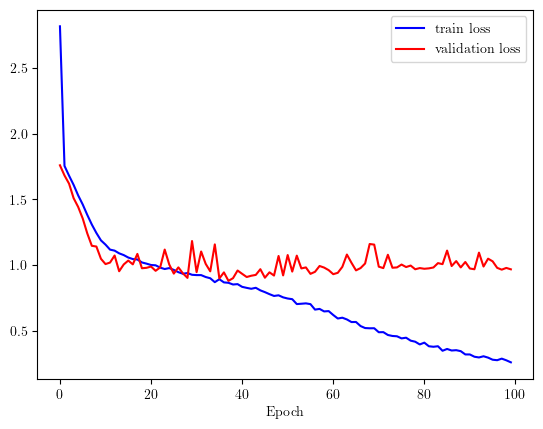

In [13]:
params_table = parameters_table(
    dataset=params.learning.DATASET, learning_params=LEARNING_PARAMS
)

# Set the path to the results directory
if params.learning.LOG_DIR:
    results_directory = Path("logs/_" + params.learning.LOG_DIR)
else:
    results_directory = Path(
        "logs/_" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
    )

generate_log(
    results_directory=results_directory,
    test_regression_loss=test_regression_loss,
    parameters_table=params_table,
    model=model,
    regression_loss_values=regression_loss_values,
)

#### Comparing to the worst possible loss

In [14]:
dataset_dir = (
    PROJECT_PATH
    / "datasets/dataset_multimodal_siamese_png_quantilebinning/traversal_costs.csv"
)
costs_df = pd.read_csv(dataset_dir)
costs = costs_df["traversal_cost"].to_numpy()
mean_dataset_value = costs_df["traversal_cost"].mean()

print(mean_dataset_value)

mean_loss = 0.0

# Add a progress bar
train_loader_pbar = tqdm(train_loader, unit="batch")

# Loop over the training batches
for images, traversal_costs, linear_velocities in train_loader_pbar:
    mean_tensor_value = torch.tensor(
        np.full(list(traversal_costs.shape), mean_dataset_value),
        dtype=torch.float32,
    )

    # loss = criterion_classification(mean_tensor_label, traversability_labels)
    #
    ## Accumulate batch loss to average over the epoch
    # train_loss += loss.item()
    #
    ## Get the number of correct predictions
    # train_correct += torch.sum(
    #    torch.argmax(mean_tensor_label, dim=1) == traversability_labels
    #    ).item()

    # Compute and accumulate the batch loss
    mean_loss += criterion_regression(
        mean_tensor_value, traversal_costs
    ).item()

# Compute the losses and accuracies
mean_loss /= len(train_loader)

print(mean_loss)

KeyError: 'traversal_cost'

#### Getting some stats about the dataset

## Assessing the relevance of the uncertainty

In [ ]:
##import uncertainty.functions
##import uncertainty.evaluation
##
### Compute the test losses after successive removal of the samples
### with the highest loss and uncertainty
##test_losses_loss, test_losses_uncertainty =\
##    uncertainty.evaluation.uncertainty_relevance(
##        model,
##        device,
##        criterion_regression,
##        uncertainty_function,
##        test,
##        test_set,
##        test_regression_loss,
##        test_regression_losses)

#### Plotting the results

In [ ]:
##plt.plot(range(0, 100, 10),
##         test_losses_loss,
##         "bo--",
##         label="removing samples with highest regression loss",
##         markersize=4)
##plt.plot(range(0, 100, 10),
##         test_losses_uncertainty,
##         "ro--",
##         label="removing samples with highest uncertainty",
##         markersize=4)
##
##plt.legend(loc="upper right")
##plt.xlabel("Percentage of samples removed")
##plt.ylabel("Regression error (MSE)")

### Ensemble learning

#### Training the models

In [ ]:
# Create a list of models
nb_models = 3
some_models = [ResNet18Velocity().to(device=device) for _ in range(nb_models)]

# Loop over the models
for i in range(nb_models):
    print(f"Training model {i+1}/{nb_models}")

    # Get all the parameters excepts the weights and bias of fc layer
    base_params = [
        param
        for name, param in some_models[i].named_parameters()
        if name not in ["resnet18.fc.weight", "resnet18.fc.bias"]
    ]

    # Define the optimizer, with a greater learning rate for the new fc layer
    optimizer = optim.SGD(
        [
            {"params": base_params},
            {
                "params": some_models[i].resnet18.fc.parameters(),
                "lr": LEARNING_PARAMS["learning_rate"] * 10,
            },
        ],
        lr=LEARNING_PARAMS["learning_rate"],
        momentum=LEARNING_PARAMS["momentum"],
        weight_decay=LEARNING_PARAMS["weight_decay"],
    )

    # Loop over the epochs
    for epoch in range(LEARNING_PARAMS["nb_epochs"]):
        # Train the model
        train_loss, train_accuracy, train_regression_loss = train(
            some_models[i],
            device,
            train_loader,
            optimizer,
            criterion_classification,
            criterion_regression,
            bins_midpoints,
            epoch,
        )

In [ ]:
# Create arrays to store the test losses
# test_losses_loss = np.zeros((nb_models, 10))
# test_losses_uncertainty = np.zeros((nb_models, 10))

uncertainty_function = uncertainty.functions.shannon_entropy

# Test the models
test_regression_loss, test_regression_losses, uncertainties = test_models(
    some_models,
    device,
    test_loader,
    criterion_classification,
    criterion_regression,
    bins_midpoints,
    uncertainty_function,
)
print("Test regression loss: ", test_regression_loss)

# Compute the test losses after successive removal of the samples with the highest loss and uncertainty
(
    test_losses_loss,
    test_losses_uncertainty,
) = uncertainty.evaluation.uncertainty_relevance_models(
    some_models,
    device,
    criterion_classification,
    criterion_regression,
    bins_midpoints,
    uncertainty_function,
    test_models,
    test_set,
    test_regression_loss,
    test_regression_losses,
    uncertainties,
)

#### Plotting the results

In [ ]:
plt.plot(
    range(0, 100, 10),
    test_losses_loss,
    "bo--",
    label="removing samples with highest regression loss",
    markersize=4,
)
plt.plot(
    range(0, 100, 10),
    test_losses_uncertainty,
    "ro--",
    label="removing samples with highest uncertainty",
    markersize=4,
)

plt.legend(loc="upper right")
plt.xlabel("Percentage of samples removed")
plt.ylabel("Regression error (MSE)")